# MLPRegressor

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from statsmodels.tools.eval_measures import stde

import kerastuner as kt
import tensorflow as tf
from tensorflow.keras import models


2022-11-21 01:23:23.915495: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-21 01:23:24.057039: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-21 01:23:24.513261: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nkspartan/miniconda3/envs/tf-gpu/lib/
2022-11-21 01:23:24.513328: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfe

In [2]:
from tensorflow.python.client import device_lib

print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

2022-11-21 01:23:25.032562: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-21 01:23:25.055431: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 01:23:25.069061: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 01:23:25.069326: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Default GPU Device: /device:GPU:0


## Read the etl info results

In [3]:
df_info = pd.read_csv('../dataset_clean/options_csv_v1_etl.csv')
df_info

,remove_time_features,generic_features,remove_atypical_values,feature_combination,remove_feature_selection,remove_invalid_correlated_features
0,False,False,False,False,False,False


## Read the dataset

In [4]:
df = pd.read_csv('../dataset/V2_PlatteRiverWeir_features_merged_all.csv')
df

,Unnamed: 0.1,Unnamed: 0,SensorTime,CaptureTime,Filename,Agency,SiteNumber,TimeZone,Stage,Discharge,...,WwRawLineMin,WwRawLineMax,WwRawLineMean,WwRawLineSigma,WwCurveLineMin,WwCurveLineMax,WwCurveLineMean,WwCurveLineSigma,RiverArea,RiverWidth
0,0,0,2012-06-09 13:15:00,2012-06-09T13:09:07,statelineweir_20120609_farrell_001.jpg,USGS,6674500,MDT,2.99,916.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,49975.0,207.508733
1,1,1,2012-06-09 13:15:00,2012-06-09T13:10:29,statelineweir_20120609_farrell_002.jpg,USGS,6674500,MDT,2.99,916.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,50184.0,208.663145
2,2,2,2012-06-09 13:45:00,2012-06-09T13:44:01,statelineweir_20120609_farrell_003.jpg,USGS,6674500,MDT,2.96,873.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,50543.0,209.445067
3,3,3,2012-06-09 14:45:00,2012-06-09T14:44:30,statelineweir_20120609_farrell_004.jpg,USGS,6674500,MDT,2.94,846.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,50856.0,211.265690
4,4,4,2012-06-09 15:45:00,2012-06-09T15:44:59,statelineweir_20120609_farrell_005.jpg,USGS,6674500,MDT,2.94,846.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,51004.0,211.250274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42054,42054,42054,2019-10-11 09:00:00,2019-10-11T08:59:53,statelineweir_20191011_farrell_409.jpg,USGS,6674500,MDT,2.54,434.0,...,9284.0,77521.0,38385.370066,15952.029728,0.0,70085.0,37550.894823,16444.401209,45842.0,194.934605
42055,42055,42055,2019-10-11 10:00:00,2019-10-11T09:59:52,statelineweir_20191011_farrell_410.jpg,USGS,6674500,MDT,2.54,434.0,...,10092.0,74614.0,40162.989292,15467.708856,0.0,70061.0,39397.339095,16009.008049,42300.0,194.762264
42056,42056,42056,2019-10-11 11:00:00,2019-10-11T10:59:52,statelineweir_20191011_farrell_411.jpg,USGS,6674500,MDT,2.54,434.0,...,7067.0,83260.0,42095.946590,16770.357949,0.0,76335.0,41350.006568,17489.374617,41080.0,196.480105
42057,42057,42057,2019-10-11 12:00:00,2019-10-11T11:59:53,statelineweir_20191011_farrell_412.jpg,USGS,6674500,MDT,2.54,434.0,...,6283.0,83045.0,45345.490954,17498.432849,0.0,78882.0,44553.920296,18268.294896,40976.0,193.595245


In [5]:
df['SensorTime'] = pd.to_datetime(df['SensorTime'])
df['Year'] = df['SensorTime'].dt.year
df['Month'] = df['SensorTime'].dt.month
df['date_offset'] = (df.SensorTime.dt.month * 100 + df.SensorTime.dt.day - 320)%1300

df['Season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                      labels=['spring', 'summer', 'autumn', 'winter'])

In [6]:
df = df[["CaptureTime", "SensorTime", "Stage", "Discharge", "RiverArea", "RiverWidth", "Month", "Season", "Year"]]
df

,CaptureTime,SensorTime,Stage,Discharge,RiverArea,RiverWidth,Month,Season,Year
0,2012-06-09T13:09:07,2012-06-09 13:15:00,2.99,916.0,49975.0,207.508733,6,spring,2012
1,2012-06-09T13:10:29,2012-06-09 13:15:00,2.99,916.0,50184.0,208.663145,6,spring,2012
2,2012-06-09T13:44:01,2012-06-09 13:45:00,2.96,873.0,50543.0,209.445067,6,spring,2012
3,2012-06-09T14:44:30,2012-06-09 14:45:00,2.94,846.0,50856.0,211.265690,6,spring,2012
4,2012-06-09T15:44:59,2012-06-09 15:45:00,2.94,846.0,51004.0,211.250274,6,spring,2012
...,...,...,...,...,...,...,...,...,...
42054,2019-10-11T08:59:53,2019-10-11 09:00:00,2.54,434.0,45842.0,194.934605,10,autumn,2019
42055,2019-10-11T09:59:52,2019-10-11 10:00:00,2.54,434.0,42300.0,194.762264,10,autumn,2019
42056,2019-10-11T10:59:52,2019-10-11 11:00:00,2.54,434.0,41080.0,196.480105,10,autumn,2019
42057,2019-10-11T11:59:53,2019-10-11 12:00:00,2.54,434.0,40976.0,193.595245,10,autumn,2019


In [7]:
df.dtypes

CaptureTime            object
SensorTime     datetime64[ns]
Stage                 float64
Discharge             float64
RiverArea             float64
RiverWidth            float64
Month                   int64
Season               category
Year                    int64
dtype: object

### Remove outliers

In [8]:
df = df[df.Stage > 0]
df = df[df.Discharge > 0]

### Remove winter

In [9]:
#df = df[df.Season != "winter"]

In [10]:
df.isna().sum()

CaptureTime      0
SensorTime       0
Stage            0
Discharge        0
RiverArea        0
RiverWidth       0
Month            0
Season         126
Year             0
dtype: int64

## Divide dataset to X and Y

In [11]:
df_train = df[(df.Year >= 2012) & (df.Year <= 2016)]
df_val = df[(df.Year >= 2017) & (df.Year <= 2017)]
df_test = df[(df.Year >= 2018) & (df.Year <= 2019)]

In [12]:
df_train = df_train.drop(columns=["Year", "SensorTime", "CaptureTime"])
df_val = df_val.drop(columns=["Year", "SensorTime", "CaptureTime"])
df_test = df_test.drop(columns=["Year", "SensorTime", "CaptureTime"])

In [13]:
np.random.seed(0)

y_train = df_train[["Stage"]]
X_train = df_train[["RiverWidth", "Month"]]

temp = list(zip(X_train.values, y_train.values))
np.random.shuffle(temp)
X_train, y_train = zip(*temp)
X_train, y_train = np.array(X_train), np.array(y_train)

y_val = df_train[["Stage"]]
X_val = df_train[["RiverWidth", "Month"]]

temp = list(zip(X_val.values, y_val.values))
np.random.shuffle(temp)
X_val, y_val = zip(*temp)
X_val, y_val = np.array(X_val), np.array(y_val)


y_test = df_test[["Stage"]].values
X_test = df_test[["RiverWidth", "Month"]].values

"""temp = list(zip(X_test.values, y_test.values))
np.random.shuffle(temp)
X_test, y_test = zip(*temp)
X_test, y_test = np.array(X_test), np.array(y_test)"""

'temp = list(zip(X_test.values, y_test.values))\nnp.random.shuffle(temp)\nX_test, y_test = zip(*temp)\nX_test, y_test = np.array(X_test), np.array(y_test)'

In [14]:
print(X_train.shape)
print(y_train.shape)

(17641, 2)
(17641, 1)


In [15]:
input_shape = X_train.shape[1]
output_shape = y_train.shape[1]

print(input_shape, output_shape)

2 1


## Train model

In [16]:
def model_builder(lr):
  model = tf.keras.Sequential()
  model.add(tf.keras.Input(shape=input_shape))
  
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512

  model.add(tf.keras.layers.Dense(32, activation="tanh"))
  model.add(tf.keras.layers.Dense(64, activation="tanh"))
  model.add(tf.keras.layers.Dense(128, activation="tanh"))
  model.add(tf.keras.layers.Dense(64, activation="tanh"))
  """model.add(tf.keras.layers.Dense(256, activation="tanh"))
  model.add(tf.keras.layers.Dense(512, activation="tanh"))
  model.add(tf.keras.layers.Dense(512, activation="tanh"))
  model.add(tf.keras.layers.Dense(256, activation="tanh"))
  model.add(tf.keras.layers.Dense(256, activation="tanh"))
  model.add(tf.keras.layers.Dense(128, activation="tanh"))
  model.add(tf.keras.layers.Dense(64, activation="tanh"))
  model.add(tf.keras.layers.Dense(32, activation="tanh"))"""


  model.add(tf.keras.layers.Dense(output_shape, activation = 'linear'))

  
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr), loss = 'mae', metrics = ['mse', tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mae', 'mape'])
  
  return model

In [17]:
model = model_builder(1e-3)

2022-11-21 01:23:26.436526: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 01:23:26.436748: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 01:23:26.436901: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 01:23:26.437219: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 01:23:26.437383: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [18]:
import datetime

date_actual = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + date_actual
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"model_weights/{date_actual}_mlp_best_weights.hdf5",
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True)

In [19]:
model.fit(X_train, y_train, epochs = 1000, batch_size = 64, validation_data = (X_val, y_val), callbacks=[checkpoint_callback, es_callback, tf.keras.callbacks.ReduceLROnPlateau(patience=40)])

Epoch 1/1000
269/276 [============================>.] - ETA: 0s - loss: 0.7281 - mse: 1.0288 - rmse: 1.0143 - mae: 0.7281 - mape: 23.3239
Epoch 1: val_loss improved from inf to 0.69936, saving model to model_weights/20221121-012326_mlp_best_weights.hdf5
276/276 [==============================] - 2s 3ms/step - loss: 0.7267 - mse: 1.0247 - rmse: 1.0123 - mae: 0.7267 - mape: 23.2860 - val_loss: 0.6994 - val_mse: 0.9458 - val_rmse: 0.9725 - val_mae: 0.6994 - val_mape: 22.4627 - lr: 0.0010
Epoch 2/1000
266/276 [===========================>..] - ETA: 0s - loss: 0.6773 - mse: 0.9580 - rmse: 0.9788 - mae: 0.6773 - mape: 21.1961
Epoch 2: val_loss improved from 0.69936 to 0.52965, saving model to model_weights/20221121-012326_mlp_best_weights.hdf5
276/276 [==============================] - 1s 3ms/step - loss: 0.6725 - mse: 0.9561 - rmse: 0.9778 - mae: 0.6725 - mape: 20.9870 - val_loss: 0.5296 - val_mse: 0.8296 - val_rmse: 0.9108 - val_mae: 0.5296 - val_mape: 15.2745 - lr: 0.0010
Epoch 3/1000
276

## Test model

In [20]:
print(date_actual)

20221121-012326


In [21]:
best_model = models.load_model(f'model_weights/{date_actual}_mlp_best_weights.hdf5')

In [22]:
best_model.evaluate(X_test, y_test)


333/333 [==============================] - 1s 1ms/step - loss: 0.3089 - mse: 0.2179 - rmse: 0.4669 - mae: 0.3089 - mape: 11.1179


[0.30886051058769226,
 0.21794913709163666,
 0.466850221157074,
 0.30886051058769226,
 11.117944717407227]

In [23]:
y_pred = best_model.predict(X_test)

333/333 [==============================] - 0s 612us/step


In [24]:
print("R^2: ", r2_score(y_test, y_pred))
print("mse: ", mean_squared_error(y_test, y_pred))
print("rmse: ", mean_squared_error(y_test, y_pred, squared=False))
print("mae: ", mean_absolute_error(y_test, y_pred))
print("mape: ", mean_absolute_percentage_error(y_test, y_pred))
print("Error estandar: ", stde(y_test.squeeze(),
      y_pred.squeeze(), ddof=2))


R^2:  0.45470996768152927
mse:  0.21794910466185902
rmse:  0.4668501950967344
mae:  0.3088604337823054
mape:  0.1111794963355979
Error estandar:  0.4637838541964875


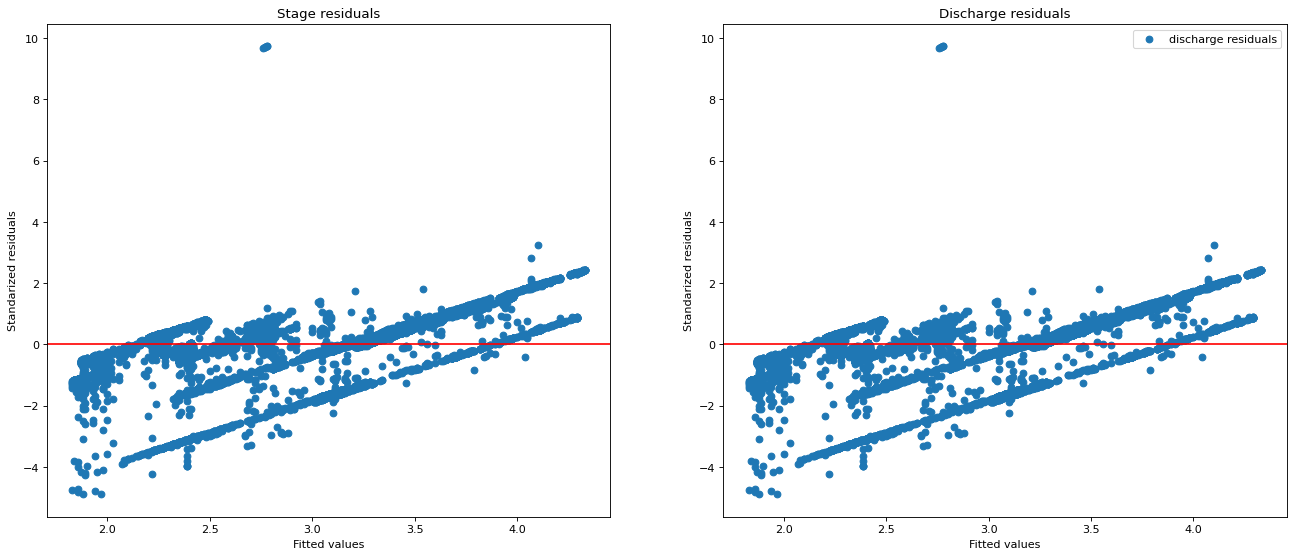

In [25]:
residuals = y_test - y_pred
residuals_std = residuals/residuals.std()

y_real_stage = np.array([i[0] for i in y_test])
residual_stage = np.array([i[0] for i in residuals])

y_real_discharge = np.array([i[-1] for i in y_test])
residual_discharge = np.array([i[-1] for i in residuals])


figure, ax = plt.subplots(ncols=2, figsize=(20, 8), dpi=80)

ax[0].scatter(y_real_stage, residual_stage / residual_stage.std(), label="stage residuals")
ax[1].scatter(y_real_discharge, residual_discharge / residual_discharge.std(), label="discharge residuals")
ax[0].axhline(y=0.0, color='r', linestyle='-')
ax[1].axhline(y=0.0, color='r', linestyle='-')

ax[0].set_title("Stage residuals")
ax[1].set_title("Discharge residuals")

ax[1].set_xlabel("Fitted values")
ax[0].set_xlabel("Fitted values")
ax[1].set_ylabel("Standarized residuals")
ax[0].set_ylabel("Standarized residuals")

plt.legend()
plt.show()

In [26]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import normal_ad

#figure = sm.qqplot(residual_stage / residual_stage.std(), line ='45', label='stage')
plt.show()

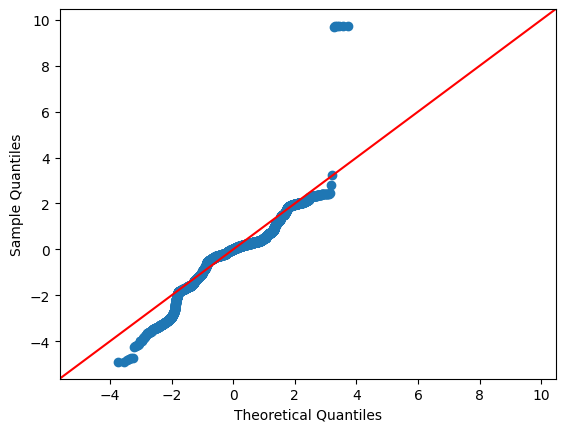

In [27]:
figure = sm.qqplot(residual_discharge / residual_discharge.std(), line='45', label='discharge')
plt.show()

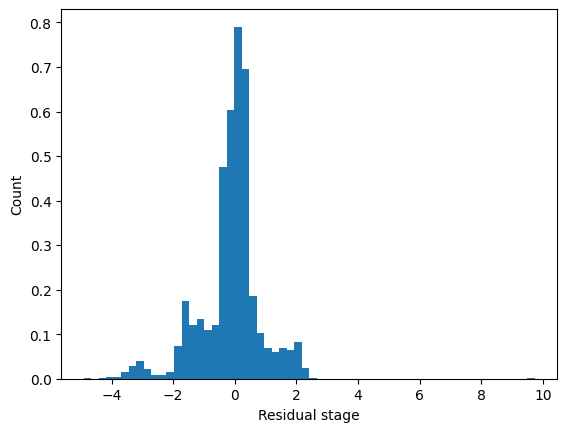

In [28]:
plt.hist(residual_stage / residual_stage.std(), density=True, bins = 60)
plt.ylabel('Count')
plt.xlabel('Residual stage');
plt.show()

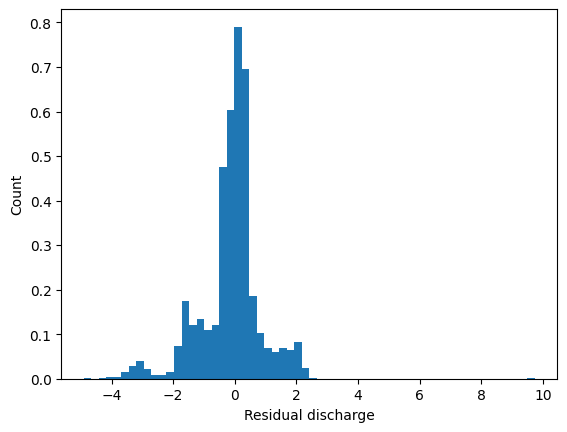

In [29]:
plt.hist(residual_discharge / residual_discharge.std(), density=True, bins = 60)
plt.ylabel('Count')
plt.xlabel('Residual discharge');
plt.show()

In [30]:
stat, pval = normal_ad(residual_discharge / residual_discharge.std())
print("p-value:", pval)

if pval < 0.05:
    print("Hay evidencia de que los residuos no provienen de una distribución normal.")
else:
    print("No hay evidencia para rechazar la hipótesis de que los residuos vienen de una distribución normal.")


p-value: 0.0
Hay evidencia de que los residuos no provienen de una distribución normal.


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/statsmodels/stats/_adnorm.py:70: RuntimeWarning: divide by zero encountered in log1p
  s = np.sum((2 * i[sl1] - 1.0) / nobs * (np.log(z) + np.log1p(-z[sl2])),


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


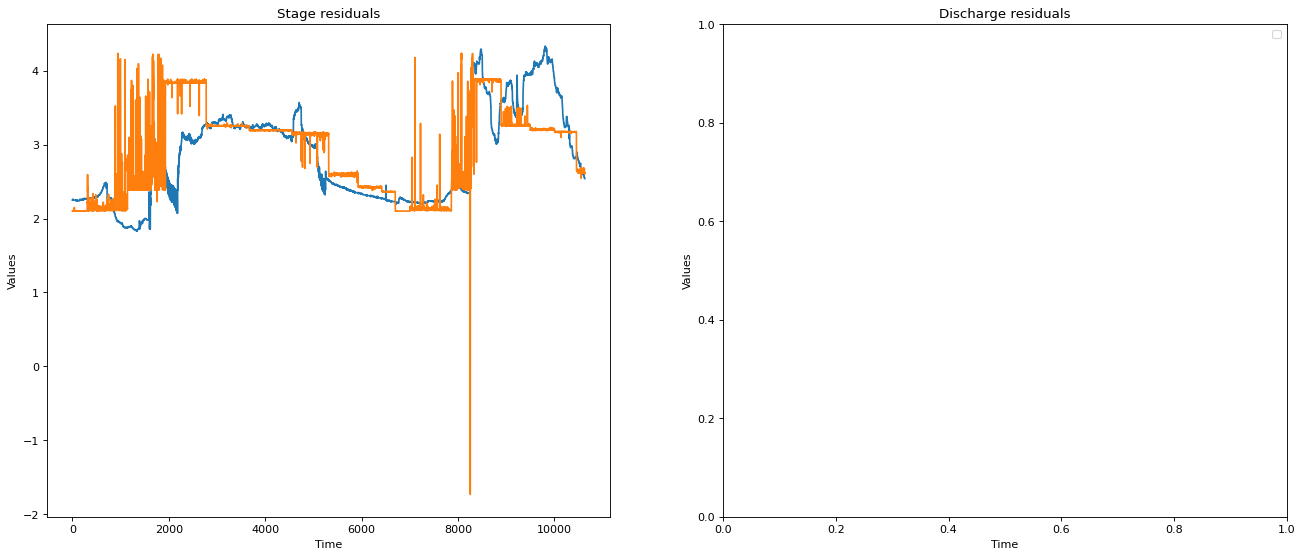

In [31]:
figure, ax = plt.subplots(ncols=2, figsize=(20, 8), dpi=80)

ax[0].plot(np.arange(len(y_test)), y_test, label="Stage real")
ax[0].plot(np.arange(len(y_test)), y_pred, label="Stage pred")

ax[0].set_title("Stage residuals")
ax[1].set_title("Discharge residuals")

ax[1].set_ylabel("Values")
ax[0].set_ylabel("Values")
ax[1].set_xlabel("Time")
ax[0].set_xlabel("Time")

plt.legend()
plt.show()